In [1]:
import sys
sys.path.insert(0, '../libraries')


from dataloader import load_dataset,create_patch_dataset_return_shifts
from utils import safe_mkdir,upsampling_without_aggregation_all_imageset,upsampling_mask_all_imageset,registration_imageset_against_best_image_without_union_mask
import numpy as np
import pandas as pd
from skimage.feature import register_translation
import os
import glob
from collections import defaultdict
%reload_ext autoreload
%autoreload 2



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
dir_pickles_probav='./pickles/'
out_dataset='./dataset'
safe_mkdir(out_dataset)
base_dir='./probav_data'
#base_dir='/home/bordone/Superresolution/data/probav_data/'

# For TRAINING Upsampling network NIR channel

In [5]:
split=0.7
band='NIR'
input_images_LR = np.load(os.path.join(dir_pickles_probav, 'LR_dataset_{0}.npy'.format(band)))
mask_LR = np.load(os.path.join(dir_pickles_probav, 'LR_mask_{0}.npy'.format(band)))
input_images_HR = np.load(os.path.join(dir_pickles_probav, 'HR_dataset_{0}.npy'.format(band)))
mask_HR = np.load(os.path.join(dir_pickles_probav, 'HR_mask_{0}.npy'.format(band)))

#To Compute the PSNR
#norm baseline for each imageset to normalize cPSNR
df_norm=pd.read_csv(os.path.join(base_dir, 'norm.csv'),sep=' ',header=None)
df_norm.columns=['set','norm']
train_dir = os.path.join(base_dir, 'train/{0}'.format(band))
dir_list=sorted([os.path.basename(x) for x in glob.glob(train_dir+'/imgset*')])
norm=df_norm.loc[df_norm['set'].isin(dir_list)]['norm'].values
norm=norm.reshape([norm.shape[0],1])

from sklearn.utils import shuffle

input_images_LR,mask_LR,input_images_HR,mask_HR,norm = shuffle(input_images_LR,
                                                          mask_LR,
                                                          input_images_HR,
                                                          mask_HR, 
                                                          norm,
                                                          random_state=1)

#Split training set and validation set
N_training_samples=int(split*len(input_images_LR))
input_images_LR_train,input_images_LR_valid=input_images_LR[0:N_training_samples],input_images_LR[N_training_samples:]
mask_LR_train,mask_LR_valid=mask_LR[0:N_training_samples],mask_LR[N_training_samples:]
input_images_HR_train,input_images_HR_valid=input_images_HR[0:N_training_samples],input_images_HR[N_training_samples:]
mask_HR_train,mask_HR_valid=mask_HR[0:N_training_samples],mask_HR[N_training_samples:]

norm_training,norm_validation=norm[0:N_training_samples],norm[N_training_samples:]

### Have a look at a LR image

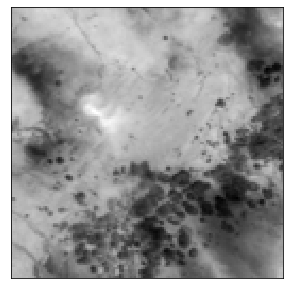

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((input_images_LR_train[0][16]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# Pre-processing, hidden regions, bad intensity values

In [7]:
#transform in a list of numpy
input_images_LR_train=np.array([np.array(x) for x in input_images_LR_train])
mask_LR_train=np.array([np.array(x) for x in mask_LR_train])

### The images are supposed to be over 14 bits, but there many images with values > 2^14 -1
### Removing all images in which we find at least one pixel > 60000.

In [8]:
#Find the indexes to remove with very high pixels
images_to_remove=[[i,j] for i,x in enumerate(input_images_LR_train) for j,z in enumerate(x) if (z>60000).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
d=defaultdict(list)
for i in images_to_remove:
    d[i[0]].append(i[1])

In [9]:
for i in d.keys():
    input_images_LR_train[i]\
    =np.delete(input_images_LR_train[i],d[i],axis=0)
    
    mask_LR_train[i]\
    =np.delete(mask_LR_train[i],d[i],axis=0)

### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [10]:
[x.shape for x in input_images_LR_train if x.shape[0]<9]

[(8, 128, 128), (7, 128, 128), (8, 128, 128), (8, 128, 128)]

### Remove them LR images, LR masks and HR images and HR masks

In [11]:
indexes=[i for i,x in enumerate(input_images_LR_train) if np.array(x).shape[0]<9]

#LR
input_images_LR_train=np.delete(input_images_LR_train,indexes,axis=0)
mask_LR_train=np.delete(mask_LR_train,indexes,axis=0)

#HR
input_images_HR_train=np.delete(input_images_HR_train,indexes,axis=0)
mask_HR_train=np.delete(mask_HR_train,indexes,axis=0)

## Upsampling

### Upsampling batch training set

The goal is to upsample all LR images of each imageset loaded from pickles

In [12]:
input_images_LR_train_upsample=upsampling_without_aggregation_all_imageset(input_images_LR_train,scale=3)

### Upsampling masks corresponding to training set

In [13]:
mask_LR_train_upsample=upsampling_mask_all_imageset(mask_LR_train,scale=3)

### Register imageset and mask



#### Registration taking always the most clear image as reference

In [15]:
input_images_LR_train_upsample_registered,\
mask_LR_train_upsample_registered,\
shifts,\
new_index_orders=registration_imageset_against_best_image_without_union_mask(input_images_LR_train_upsample,
                                                mask_LR_train_upsample,
                                                1)


In [16]:
new_index_orders[17]

array([18,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17], dtype=int16)

In [17]:
shifts[17]

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [-1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [-1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [-1.,  0.],
       [ 0.,  0.],
       [-1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [-1.,  0.]])

In [18]:
#transform in a list of numpy
input_images_LR_train_upsample=np.array([np.array(x) for x in input_images_LR_train_upsample])
mask_LR_train_upsample=np.array([np.array(x) for x in mask_LR_train_upsample])

In [19]:
#Reorder the training set not upsampled and not registered the way the training upsdampled and registered has been ordered
#so that it matched the ordering of the shifts we computed during registration

input_images_LR_train_upsample=[imageset[new_index_orders[i]] for i,imageset in enumerate(input_images_LR_train_upsample)]
mask_LR_train_upsample=[imageset[new_index_orders[i]] for i,imageset in enumerate(mask_LR_train_upsample)]


In [20]:
#Find the indexes to remove considering we want to keep up to 4 pixel shift. 
images_to_remove=[[i,j,z] for i,x in enumerate(shifts) for j,z in enumerate(x) if (np.abs(z)>4).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
from collections import defaultdict

d=defaultdict(list)

for i in images_to_remove:
    d[i[0]].append(i[1])
    


In [21]:
d

defaultdict(list,
            {3: [13],
             11: [16],
             21: [4, 5, 9, 13],
             23: [1],
             34: [10, 13],
             44: [16],
             59: [4, 11, 17],
             63: [3],
             65: [18],
             80: [16],
             87: [1],
             96: [16],
             100: [11],
             110: [12],
             116: [6],
             117: [5],
             120: [5],
             121: [12],
             131: [9, 15],
             139: [9],
             143: [16, 22],
             162: [14],
             165: [16],
             172: [13, 20],
             174: [4],
             175: [19],
             181: [2, 13, 17, 25, 26, 27],
             187: [11, 26],
             190: [14],
             191: [18],
             193: [7, 15],
             197: [17],
             206: [13],
             208: [5],
             214: [11, 14],
             218: [6],
             221: [18],
             222: [15],
             234: [5],
         

### Remove the images from LR images

In [22]:
for i in d.keys():
    input_images_LR_train_upsample[i]\
    =np.delete(input_images_LR_train_upsample[i],d[i],axis=0)
    
    mask_LR_train_upsample[i]\
    =np.delete(mask_LR_train_upsample[i],d[i],axis=0)


### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [23]:
[x.shape for x in input_images_LR_train_upsample if x.shape[0]<9]

[(8, 384, 384)]

In [24]:
len([x.shape for x in input_images_LR_train_upsample if x.shape[0]<9])

1

### Remove them LR images, LR masks and HR images and HR masks

In [25]:
indexes=[i for i,x in enumerate(input_images_LR_train_upsample) if np.array(x).shape[0]<9]

#LR
input_images_LR_train_upsample=np.delete(input_images_LR_train_upsample,indexes,axis=0)
mask_LR_train_upsample=np.delete(mask_LR_train_upsample,indexes,axis=0)

#HR
input_images_HR_train=np.delete(input_images_HR_train,indexes,axis=0)
mask_HR_train=np.delete(mask_HR_train,indexes,axis=0)

In [26]:
indexes

[23]

In [27]:
# Update also shifts array
for i in d.keys():
    shifts[i]\
    =np.delete(shifts[i],d[i],axis=0)

shifts=np.delete(shifts,indexes,axis=0)

### Statistics about the shifts

In [28]:
len([[i,j,z] for i,x in enumerate(shifts) for j,z in enumerate(x) if (np.abs(z)==0).all() ])

4047

In [29]:
len([[i,j,z] for i,x in enumerate(shifts) for j,z in enumerate(x) if (np.abs(z)>=0).any() ])

7247

### Create patches from the upsamled LR images and save npy 

In [30]:
n_chuncks=5
for i in range(n_chuncks):
    dataset_patch=create_patch_dataset_return_shifts(input_images_LR_train_upsample,
                                                     input_images_HR_train,
                                                     mask_LR_train_upsample,
                                                     mask_HR_train,
                                                     shifts,
                                                     patch_size=96,
                                                     num_patches_per_set=20,
                                                     scale=1,
                                                     smart_patching=True
                                                     )
    
    input_images_LR_patch=dataset_patch['training_patch']
    input_images_HR_patch=dataset_patch['training_y_patch']
    mask_LR_patch=dataset_patch['training_mask_patch']
    mask_HR_patch=dataset_patch['training_mask_y_patch']
    shifts_patch=dataset_patch['shifts']
    coordinates=dataset_patch['coordinates']
    
    np.save(os.path.join(out_dataset,'{0}_dataset_{1}_patch_LR.npy'.format(i,band)),input_images_LR_patch,allow_pickle=True)
    np.save(os.path.join(out_dataset,'{0}_dataset_{1}_patch_HR.npy'.format(i,band)),input_images_HR_patch,allow_pickle=True)
    np.save(os.path.join(out_dataset,'{0}_dataset_{1}_patch_mask_LR.npy'.format(i,band)),mask_LR_patch,allow_pickle=True)
    np.save(os.path.join(out_dataset,'{0}_dataset_{1}_patch_mask_HR.npy'.format(i,band)),mask_HR_patch,allow_pickle=True)
    np.save(os.path.join(out_dataset,'{0}_shifts_patch_{1}.npy'.format(i,band)),shifts_patch,allow_pickle=True)
    np.save(os.path.join(out_dataset,'{0}_coordinates_{1}.npy'.format(i,band)),coordinates,allow_pickle=True)
    

[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


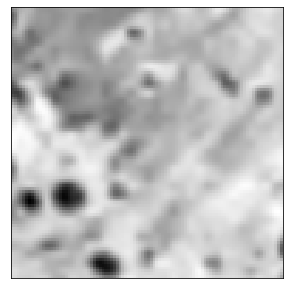

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((input_images_LR_patch[14][8]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

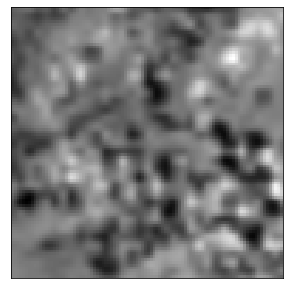

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((input_images_LR_patch[14][13]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

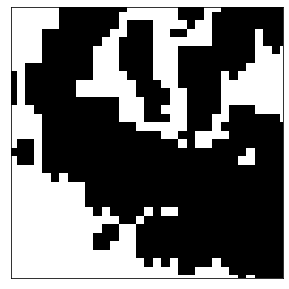

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((mask_LR_patch[14][13]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

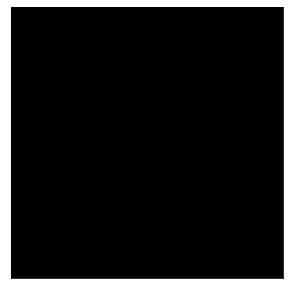

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((mask_LR_patch[23][0]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

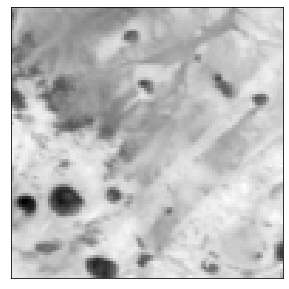

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((input_images_HR_patch[14]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# For Validation Upsampling network NIR channel

In [36]:
#transform in a list of numpy
input_images_LR_valid=np.array([np.array(x) for x in input_images_LR_valid])
mask_LR_valid=np.array([np.array(x) for x in mask_LR_valid])

### Removing all images in which we find at least one pixel > 65000

In [37]:
#Find the indexes to remove with very high pixels
images_to_remove=[[i,j] for i,x in enumerate(input_images_LR_valid) for j,z in enumerate(x) if (z>60000).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
from collections import defaultdict

d=defaultdict(list)

for i in images_to_remove:
    d[i[0]].append(i[1])
    


In [38]:
d

defaultdict(list,
            {0: [15],
             1: [15],
             3: [1],
             4: [7, 10],
             5: [14],
             6: [9, 13],
             7: [4, 7, 13],
             14: [6],
             15: [9],
             16: [3],
             17: [5],
             22: [2],
             24: [6, 9],
             25: [8, 14],
             26: [8],
             28: [3, 18],
             29: [13],
             31: [6, 12],
             32: [5, 13],
             33: [0, 2],
             35: [8],
             36: [11],
             39: [6, 13],
             40: [9],
             42: [22],
             43: [4, 10],
             45: [5, 9],
             46: [5],
             49: [2],
             50: [0, 6, 16],
             51: [9],
             55: [2],
             59: [9],
             62: [2],
             63: [0],
             64: [1, 4],
             67: [0],
             68: [4],
             74: [4],
             78: [0],
             79: [18],
             80: [12, 

In [39]:
for i in d.keys():
    input_images_LR_valid[i]\
    =np.delete(input_images_LR_valid[i],d[i],axis=0)
    
    mask_LR_valid[i]\
    =np.delete(mask_LR_valid[i],d[i],axis=0)

### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [40]:
[x.shape for x in input_images_LR_valid if x.shape[0]<9]

[]

### Remove them LR images, LR masks and HR images and HR masks

In [41]:
indexes=[i for i,x in enumerate(input_images_LR_valid) if np.array(x).shape[0]<9]

#LR
input_images_LR_valid=np.delete(input_images_LR_valid,indexes,axis=0)
mask_LR_valid=np.delete(mask_LR_valid,indexes,axis=0)

#HR
input_images_HR_valid=np.delete(input_images_HR_valid,indexes,axis=0)
mask_HR_valid=np.delete(mask_HR_valid,indexes,axis=0)

In [42]:
#update the baseline normalization
norm_validation=np.delete(norm_validation,indexes,axis=0)

## Upsampling

### Upsampling batch training set

The goal is to upsample all LR images of each imageset loaded from pickles

In [43]:
input_images_LR_valid_upsample=upsampling_without_aggregation_all_imageset(input_images_LR_valid,scale=3)

### Upsampling masks corresponding to training set

In [44]:
mask_LR_valid_upsample=upsampling_mask_all_imageset(mask_LR_valid,scale=3)

### Register imageset and mask

In [48]:
input_images_LR_valid_upsample_registered,\
mask_LR_valid_upsample_registered,\
shifts_valid,\
new_index_orders_valid=registration_imageset_against_best_image_without_union_mask(input_images_LR_valid_upsample,
                                                mask_LR_valid_upsample,
                                                1)




In [49]:
#transform in a list of numpy
input_images_LR_valid_upsample=np.array([np.array(x) for x in input_images_LR_valid_upsample])
mask_LR_valid_upsample=np.array([np.array(x) for x in mask_LR_valid_upsample])

In [50]:
#Reorder the training set not upsampled and not registered the way the training upsdampled and registered has been ordered
#so that it matched the ordering of the shifts we computed during registration

input_images_LR_valid_upsample=[imageset[new_index_orders_valid[i]] for i,imageset in enumerate(input_images_LR_valid_upsample)]
mask_LR_valid_upsample=[imageset[new_index_orders_valid[i]] for i,imageset in enumerate(mask_LR_valid_upsample)]


In [51]:
# Find the indexes to remove

images_to_remove=[[i,j,z] for i,x in enumerate(shifts_valid) for j,z in enumerate(x) if (np.abs(z)>4).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
from collections import defaultdict

d=defaultdict(list)

for i in images_to_remove:
    d[i[0]].append(i[1])
    


In [52]:
d

defaultdict(list,
            {8: [4],
             9: [15],
             13: [7],
             26: [11],
             29: [10, 18],
             34: [3],
             51: [11],
             58: [10, 11],
             66: [6],
             95: [18],
             97: [4, 5],
             111: [10, 15],
             118: [2, 9, 11],
             128: [6, 9],
             130: [3, 16],
             159: [6, 22],
             164: [3, 6],
             165: [15]})

### Remove the images from LR images

In [53]:
for i in d.keys():
    input_images_LR_valid_upsample[i]\
    =np.delete(input_images_LR_valid_upsample[i],d[i],axis=0)
    
    mask_LR_valid_upsample[i]\
    =np.delete(mask_LR_valid_upsample[i],d[i],axis=0)


### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [54]:
[x.shape for x in input_images_LR_valid_upsample if x.shape[0]<9]

[]

In [55]:
len([x.shape for x in input_images_LR_valid_upsample if x.shape[0]<9])

0

### Remove them

In [56]:
indexes=[i for i,x in enumerate(input_images_LR_valid_upsample) if np.array(x).shape[0]<9]

#LR
input_images_LR_valid_upsample=np.delete(input_images_LR_valid_upsample,indexes,axis=0)
mask_LR_valid_upsample=np.delete(mask_LR_valid_upsample,indexes,axis=0)

#HR
input_images_HR_valid=np.delete(input_images_HR_valid,indexes,axis=0)
mask_HR_valid=np.delete(mask_HR_valid,indexes,axis=0)

In [57]:
indexes

[]

In [58]:
# Update also shifts array

for i in d.keys():
    shifts_valid[i]\
    =np.delete(shifts_valid[i],d[i],axis=0)

shifts_valid=np.delete(shifts_valid,indexes,axis=0)

In [59]:
#update the baseline normalization
norm_validation=np.delete(norm_validation,indexes,axis=0)

### Save the validation dataset

In [60]:
np.save(os.path.join(out_dataset,'dataset_{0}_LR_valid.npy'.format(band)),input_images_LR_valid_upsample,allow_pickle=True)
np.save(os.path.join(out_dataset,'dataset_{0}_HR_valid.npy'.format(band)),input_images_HR_valid,allow_pickle=True)
np.save(os.path.join(out_dataset,'dataset_{0}_mask_LR_valid.npy'.format(band)),mask_LR_valid_upsample,allow_pickle=True)
np.save(os.path.join(out_dataset,'dataset_{0}_mask_HR_valid.npy'.format(band)),mask_HR_valid,allow_pickle=True)
np.save(os.path.join(out_dataset,'shifts_valid_{0}.npy'.format(band)),shifts_valid,allow_pickle=True)

norm_validation.dump(os.path.join(out_dataset,'norm_'+band+'.npy'))

# For TRAINING Upsampling network RED channel

In [4]:
split=0.7
band='RED'
input_images_LR = np.load(os.path.join(dir_pickles_probav, 'LR_dataset_{0}.npy'.format(band)))
mask_LR = np.load(os.path.join(dir_pickles_probav, 'LR_mask_{0}.npy'.format(band)))
input_images_HR = np.load(os.path.join(dir_pickles_probav, 'HR_dataset_{0}.npy'.format(band)))
mask_HR = np.load(os.path.join(dir_pickles_probav, 'HR_mask_{0}.npy'.format(band)))

#To Compute the PSNR
#norm baseline for each imageset to normalize cPSNR
df_norm=pd.read_csv(os.path.join(base_dir, 'norm.csv'),sep=' ',header=None)
df_norm.columns=['set','norm']
train_dir = os.path.join(base_dir, 'train/{0}'.format(band))
dir_list=sorted([os.path.basename(x) for x in glob.glob(train_dir+'/imgset*')])
norm=df_norm.loc[df_norm['set'].isin(dir_list)]['norm'].values
norm=norm.reshape([norm.shape[0],1])

from sklearn.utils import shuffle

input_images_LR,mask_LR,input_images_HR,mask_HR,norm = shuffle(input_images_LR,
                                                          mask_LR,
                                                          input_images_HR,
                                                          mask_HR, 
                                                          norm,
                                                          random_state=1)

#Split training set and validation set
N_training_samples=int(split*len(input_images_LR))
input_images_LR_train,input_images_LR_valid=input_images_LR[0:N_training_samples],input_images_LR[N_training_samples:]
mask_LR_train,mask_LR_valid=mask_LR[0:N_training_samples],mask_LR[N_training_samples:]
input_images_HR_train,input_images_HR_valid=input_images_HR[0:N_training_samples],input_images_HR[N_training_samples:]
mask_HR_train,mask_HR_valid=mask_HR[0:N_training_samples],mask_HR[N_training_samples:]

norm_training,norm_validation=norm[0:N_training_samples],norm[N_training_samples:]

### Have a look at a LR image

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((input_images_LR_train[0][0]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<Figure size 500x500 with 1 Axes>

# Pre-processing, hidden regions, bad intensity values

In [6]:
#transform in a list of numpy
input_images_LR_train=np.array([np.array(x) for x in input_images_LR_train])
mask_LR_train=np.array([np.array(x) for x in mask_LR_train])

### The images are supposed to be over 14 bits, but there many images with values > 2^14 -1
### Removing all images in which we find at least one pixel > 60000.

In [7]:
#Find the indexes to remove with very high pixels
images_to_remove=[[i,j] for i,x in enumerate(input_images_LR_train) for j,z in enumerate(x) if (z>60000).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
d=defaultdict(list)
for i in images_to_remove:
    d[i[0]].append(i[1])

In [8]:
for i in d.keys():
    input_images_LR_train[i]\
    =np.delete(input_images_LR_train[i],d[i],axis=0)
    
    mask_LR_train[i]\
    =np.delete(mask_LR_train[i],d[i],axis=0)

### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [9]:
[x.shape for x in input_images_LR_train if x.shape[0]<9]

[(8, 128, 128), (7, 128, 128), (8, 128, 128), (7, 128, 128)]

### Remove them LR images, LR masks and HR images and HR masks

In [10]:
indexes=[i for i,x in enumerate(input_images_LR_train) if np.array(x).shape[0]<9]

#LR
input_images_LR_train=np.delete(input_images_LR_train,indexes,axis=0)
mask_LR_train=np.delete(mask_LR_train,indexes,axis=0)

#HR
input_images_HR_train=np.delete(input_images_HR_train,indexes,axis=0)
mask_HR_train=np.delete(mask_HR_train,indexes,axis=0)

## Upsampling

### Upsampling batch training set

The goal is to upsample all LR images of each imageset loaded from pickles

In [11]:
input_images_LR_train_upsample=upsampling_without_aggregation_all_imageset(input_images_LR_train,scale=3)

### Upsampling masks corresponding to training set

In [12]:
mask_LR_train_upsample=upsampling_mask_all_imageset(mask_LR_train,scale=3)

### Register imageset and mask



#### Registration taking always the most clear image as reference

In [13]:
input_images_LR_train_upsample_registered,\
mask_LR_train_upsample_registered,\
shifts,\
new_index_orders=registration_imageset_against_best_image_without_union_mask(input_images_LR_train_upsample,
                                                mask_LR_train_upsample,
                                                1)


../libraries/utils.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  imageset_training_registered[j_index]=corrected_image


In [14]:
new_index_orders[17]

array([ 2,  0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18], dtype=int16)

In [15]:
shifts[17]

array([[ 0.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1., -3.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [16]:
#transform in a list of numpy
input_images_LR_train_upsample=np.array([np.array(x) for x in input_images_LR_train_upsample])
mask_LR_train_upsample=np.array([np.array(x) for x in mask_LR_train_upsample])

In [17]:
#Reorder the training set not upsampled and not registered the way the training upsdampled and registered has been ordered
#so that it matched the ordering of the shifts we computed during registration

input_images_LR_train_upsample=[imageset[new_index_orders[i]] for i,imageset in enumerate(input_images_LR_train_upsample)]
mask_LR_train_upsample=[imageset[new_index_orders[i]] for i,imageset in enumerate(mask_LR_train_upsample)]


In [18]:
#Find the indexes to remove considering we want to keep up to 4 pixel shift. 
images_to_remove=[[i,j,z] for i,x in enumerate(shifts) for j,z in enumerate(x) if (np.abs(z)>4).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
from collections import defaultdict

d=defaultdict(list)

for i in images_to_remove:
    d[i[0]].append(i[1])
    


In [19]:
d

defaultdict(list,
            {0: [2, 3, 4, 5, 7, 8, 9, 11, 12, 13],
             15: [13],
             19: [1],
             24: [10, 18],
             26: [16],
             27: [5, 11],
             32: [3],
             49: [3],
             52: [6],
             64: [10, 13],
             66: [17],
             69: [16],
             76: [5, 6],
             81: [2, 5],
             92: [4, 8],
             96: [9],
             107: [15, 18],
             108: [4, 5, 9, 13],
             110: [17],
             116: [11],
             126: [16],
             130: [1, 5, 7],
             137: [5],
             148: [9],
             151: [16],
             157: [3],
             158: [11, 14],
             160: [18],
             174: [17],
             178: [4],
             179: [13],
             180: [12],
             182: [6, 15],
             195: [17],
             207: [14],
             209: [11],
             210: [1],
             216: [7],
             217: [3, 8, 11

### Remove the images from LR images

In [20]:
for i in d.keys():
    input_images_LR_train_upsample[i]\
    =np.delete(input_images_LR_train_upsample[i],d[i],axis=0)
    
    mask_LR_train_upsample[i]\
    =np.delete(mask_LR_train_upsample[i],d[i],axis=0)


### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [21]:
[x.shape for x in input_images_LR_train_upsample if x.shape[0]<9]

[(4, 384, 384), (8, 384, 384), (6, 384, 384), (8, 384, 384), (8, 384, 384)]

In [22]:
len([x.shape for x in input_images_LR_train_upsample if x.shape[0]<9])

5

### Remove them LR images, LR masks and HR images and HR masks

In [23]:
indexes=[i for i,x in enumerate(input_images_LR_train_upsample) if np.array(x).shape[0]<9]

#LR
input_images_LR_train_upsample=np.delete(input_images_LR_train_upsample,indexes,axis=0)
mask_LR_train_upsample=np.delete(mask_LR_train_upsample,indexes,axis=0)

#HR
input_images_HR_train=np.delete(input_images_HR_train,indexes,axis=0)
mask_HR_train=np.delete(mask_HR_train,indexes,axis=0)

In [24]:
indexes

[0, 81, 130, 333, 403]

In [25]:
# Update also shifts array
for i in d.keys():
    shifts[i]\
    =np.delete(shifts[i],d[i],axis=0)

shifts=np.delete(shifts,indexes,axis=0)

### Statistics about the shifts

In [26]:
len([[i,j,z] for i,x in enumerate(shifts) for j,z in enumerate(x) if (np.abs(z)==0).all() ])

4266

In [27]:
len([[i,j,z] for i,x in enumerate(shifts) for j,z in enumerate(x) if (np.abs(z)>=0).any() ])

7480

### Create patches from the upsamled LR images and save npy 

In [28]:
n_chuncks=5
for i in range(n_chuncks):
    dataset_patch=create_patch_dataset_return_shifts(input_images_LR_train_upsample,
                                                     input_images_HR_train,
                                                     mask_LR_train_upsample,
                                                     mask_HR_train,
                                                     shifts,
                                                     patch_size=96,
                                                     num_patches_per_set=20,
                                                     scale=1,
                                                     smart_patching=True
                                                     )
    
    input_images_LR_patch=dataset_patch['training_patch']
    input_images_HR_patch=dataset_patch['training_y_patch']
    mask_LR_patch=dataset_patch['training_mask_patch']
    mask_HR_patch=dataset_patch['training_mask_y_patch']
    shifts_patch=dataset_patch['shifts']
    coordinates=dataset_patch['coordinates']
    
    np.save(os.path.join(out_dataset,'{0}_dataset_{1}_patch_LR.npy'.format(i,band)),input_images_LR_patch,allow_pickle=True)
    np.save(os.path.join(out_dataset,'{0}_dataset_{1}_patch_HR.npy'.format(i,band)),input_images_HR_patch,allow_pickle=True)
    np.save(os.path.join(out_dataset,'{0}_dataset_{1}_patch_mask_LR.npy'.format(i,band)),mask_LR_patch,allow_pickle=True)
    np.save(os.path.join(out_dataset,'{0}_dataset_{1}_patch_mask_HR.npy'.format(i,band)),mask_HR_patch,allow_pickle=True)
    np.save(os.path.join(out_dataset,'{0}_shifts_patch_{1}.npy'.format(i,band)),shifts_patch,allow_pickle=True)
    np.save(os.path.join(out_dataset,'{0}_coordinates_{1}.npy'.format(i,band)),coordinates,allow_pickle=True)
    

[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


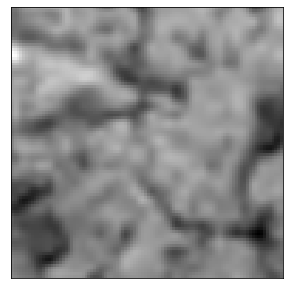

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((input_images_LR_patch[14][8]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

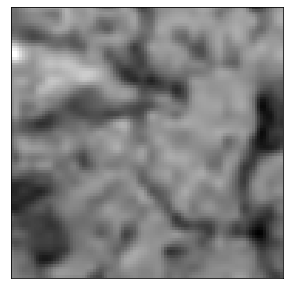

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((input_images_LR_patch[14][13]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

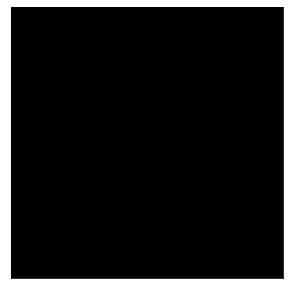

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((mask_LR_patch[14][13]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

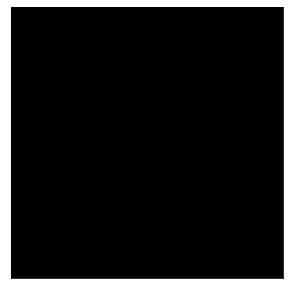

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((mask_LR_patch[23][0]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

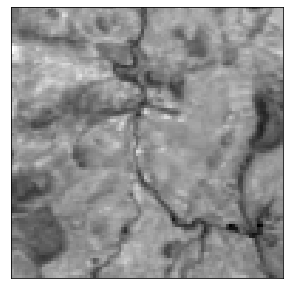

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((input_images_HR_patch[14]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# For Validation Upsampling network RED channel

In [34]:
#transform in a list of numpy
input_images_LR_valid=np.array([np.array(x) for x in input_images_LR_valid])
mask_LR_valid=np.array([np.array(x) for x in mask_LR_valid])

### Removing all images in which we find at least one pixel > 65000

In [35]:
#Find the indexes to remove with very high pixels
images_to_remove=[[i,j] for i,x in enumerate(input_images_LR_valid) for j,z in enumerate(x) if (z>60000).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
from collections import defaultdict

d=defaultdict(list)

for i in images_to_remove:
    d[i[0]].append(i[1])
    


In [36]:
d

defaultdict(list,
            {0: [15],
             1: [2],
             4: [12],
             6: [6, 12],
             7: [8],
             8: [3, 9],
             9: [14, 17],
             11: [1, 3],
             12: [5],
             14: [16],
             17: [2],
             20: [11],
             21: [6, 22, 28],
             22: [9, 12, 20],
             24: [7, 12],
             27: [1, 2, 17],
             31: [16],
             36: [9, 13],
             38: [5],
             40: [4, 5, 8],
             42: [10, 18],
             43: [12],
             44: [2],
             53: [4],
             54: [5, 10],
             55: [4, 5],
             56: [2],
             58: [1],
             60: [0, 6],
             61: [14],
             63: [6, 14],
             64: [2],
             66: [1, 14],
             70: [2, 3, 12],
             71: [2],
             73: [7, 9],
             74: [7],
             75: [7, 14],
             78: [6, 13],
             80: [18],
        

In [37]:
for i in d.keys():
    input_images_LR_valid[i]\
    =np.delete(input_images_LR_valid[i],d[i],axis=0)
    
    mask_LR_valid[i]\
    =np.delete(mask_LR_valid[i],d[i],axis=0)

### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [38]:
[x.shape for x in input_images_LR_valid if x.shape[0]<9]

[(7, 128, 128), (8, 128, 128)]

### Remove them LR images, LR masks and HR images and HR masks

In [39]:
indexes=[i for i,x in enumerate(input_images_LR_valid) if np.array(x).shape[0]<9]

#LR
input_images_LR_valid=np.delete(input_images_LR_valid,indexes,axis=0)
mask_LR_valid=np.delete(mask_LR_valid,indexes,axis=0)

#HR
input_images_HR_valid=np.delete(input_images_HR_valid,indexes,axis=0)
mask_HR_valid=np.delete(mask_HR_valid,indexes,axis=0)

In [40]:
#update the baseline normalization
norm_validation=np.delete(norm_validation,indexes,axis=0)

## Upsampling

### Upsampling batch training set

The goal is to upsample all LR images of each imageset loaded from pickles

In [41]:
input_images_LR_valid_upsample=upsampling_without_aggregation_all_imageset(input_images_LR_valid,scale=3)

### Upsampling masks corresponding to training set

In [42]:
mask_LR_valid_upsample=upsampling_mask_all_imageset(mask_LR_valid,scale=3)

### Register imageset and mask

In [44]:
input_images_LR_valid_upsample_registered,\
mask_LR_valid_upsample_registered,\
shifts_valid,\
new_index_orders_valid=registration_imageset_against_best_image_without_union_mask(input_images_LR_valid_upsample,
                                                mask_LR_valid_upsample,
                                                1)




In [45]:
#transform in a list of numpy
input_images_LR_valid_upsample=np.array([np.array(x) for x in input_images_LR_valid_upsample])
mask_LR_valid_upsample=np.array([np.array(x) for x in mask_LR_valid_upsample])

In [46]:
#Reorder the training set not upsampled and not registered the way the training upsdampled and registered has been ordered
#so that it matched the ordering of the shifts we computed during registration

input_images_LR_valid_upsample=[imageset[new_index_orders_valid[i]] for i,imageset in enumerate(input_images_LR_valid_upsample)]
mask_LR_valid_upsample=[imageset[new_index_orders_valid[i]] for i,imageset in enumerate(mask_LR_valid_upsample)]


In [47]:
# Find the indexes to remove

images_to_remove=[[i,j,z] for i,x in enumerate(shifts_valid) for j,z in enumerate(x) if (np.abs(z)>4).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
from collections import defaultdict

d=defaultdict(list)

for i in images_to_remove:
    d[i[0]].append(i[1])
    


In [48]:
d

defaultdict(list,
            {2: [5],
             6: [15],
             14: [16],
             20: [9, 23],
             25: [3, 5],
             28: [15],
             30: [4],
             36: [2, 5],
             39: [3, 14, 16],
             41: [19],
             46: [16, 22],
             48: [6],
             54: [11],
             61: [9, 14],
             71: [5],
             76: [11],
             80: [18],
             83: [14],
             87: [1],
             91: [18],
             92: [12],
             93: [5],
             99: [14],
             101: [3],
             117: [13, 20],
             122: [8],
             127: [2],
             130: [5],
             131: [4],
             133: [4],
             139: [1, 6],
             141: [17],
             145: [1, 8],
             147: [4, 5],
             149: [1],
             151: [6, 22],
             159: [11],
             160: [11],
             175: [15]})

### Remove the images from LR images

In [49]:
for i in d.keys():
    input_images_LR_valid_upsample[i]\
    =np.delete(input_images_LR_valid_upsample[i],d[i],axis=0)
    
    mask_LR_valid_upsample[i]\
    =np.delete(mask_LR_valid_upsample[i],d[i],axis=0)


### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [50]:
[x.shape for x in input_images_LR_valid_upsample if x.shape[0]<9]

[(8, 384, 384)]

In [51]:
len([x.shape for x in input_images_LR_valid_upsample if x.shape[0]<9])

1

### Remove them

In [52]:
indexes=[i for i,x in enumerate(input_images_LR_valid_upsample) if np.array(x).shape[0]<9]

#LR
input_images_LR_valid_upsample=np.delete(input_images_LR_valid_upsample,indexes,axis=0)
mask_LR_valid_upsample=np.delete(mask_LR_valid_upsample,indexes,axis=0)

#HR
input_images_HR_valid=np.delete(input_images_HR_valid,indexes,axis=0)
mask_HR_valid=np.delete(mask_HR_valid,indexes,axis=0)

In [53]:
indexes

[87]

In [54]:
# Update also shifts array

for i in d.keys():
    shifts_valid[i]\
    =np.delete(shifts_valid[i],d[i],axis=0)

shifts_valid=np.delete(shifts_valid,indexes,axis=0)

In [55]:
#update the baseline normalization
norm_validation=np.delete(norm_validation,indexes,axis=0)

### Save the validation dataset

In [56]:
np.save(os.path.join(out_dataset,'dataset_{0}_LR_valid.npy'.format(band)),input_images_LR_valid_upsample,allow_pickle=True)
np.save(os.path.join(out_dataset,'dataset_{0}_HR_valid.npy'.format(band)),input_images_HR_valid,allow_pickle=True)
np.save(os.path.join(out_dataset,'dataset_{0}_mask_LR_valid.npy'.format(band)),mask_LR_valid_upsample,allow_pickle=True)
np.save(os.path.join(out_dataset,'dataset_{0}_mask_HR_valid.npy'.format(band)),mask_HR_valid,allow_pickle=True)
np.save(os.path.join(out_dataset,'shifts_valid_{0}.npy'.format(band)),shifts_valid,allow_pickle=True)

norm_validation.dump(os.path.join(out_dataset,'norm_'+band+'.npy'))